Doctors have always written clinical notes about their patients - originally, the notes were on paper and were locked away in a cabinet. Fortunately for data scientists, doctors now enter their notes in an electronic medical record. These notes represent a vast wealth of knowledge and insight that can be utilized for predictive models using Natural Language Processing (NLP) to improve patient care and hospital workflow.

This notebook is the first part in a series of notebooks intended for people interested in healthcare data science and predictive modeling. Through this workshop, students will have the opportunity to practice
- How to prepare data for a machine learning project (discussed in this notebook)
- How to preprocess the unstructured notes
- How to build a simple predictive model using a bag-of-words approach
- How to assess the quality of your model
- How to decide the next step for improving the model

I recently read this great paper "Scalable and accurate deep learning for electronic health records" by Rajkomar et al. (paper at https://arxiv.org/abs/1801.07860). The authors built many state-of-the-art deep learning models with hospital data to predict in-hospital mortality (AUC = 0.93–0.94), 30-day unplanned readmission (AUC = 0.75–76), prolonged length of stay (AUC = 0.85–0.86) and discharge diagnoses (AUC = 0.90). AUC is a data science performance metric (more about this below) where closer to 1 is better. It is clear that predicting readmission is the hardest task since it has a lower AUC. I was curious how good of a model we can get if use the discharge free-text summaries with a simple predictive model.

# Model definition

Predict which patients are at risk for 30-day unplanned readmission utilizing free-text hospital discharge summaries.

# Data set

We will utilize the MIMIC-III (Medical Information Mart for Intensive Care III), an amazing free hospital database. This database contains de-identified data from over 40,000 patients who were admitted to Beth Israel Deaconess Medical Center in Boston, Massachusetts from 2001 to 2012. In order to get access to the data for this project, you will need to request access at this link (https://mimic.physionet.org/gettingstarted/access/).

In this project, we will make use of the following MIMIC tables
- ADMISSIONS - a table containing admission and discharge dates (has a unique identifier HADM_ID for each admission)
- NOTEEVENTS - contains all notes for each hospitalization (links with HADM_ID)

This notebook assumes that ADMISSIONS.csv and NOTEEVENTS.csv were downloaded and placed in the same folder as this notebook. 

Due to the restricted access, the github version of this code will not show any individual patient data. 

# Step 1. Prepare data

<img src="img/step_1.jpg">

## Load admissions table

In [ ]:
# set up notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read the admissions table
df_adm = pd.read_csv('data/ADMISSIONS.csv')

In [ ]:
df_adm.head()

In [35]:
df_adm.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [36]:
len(df_adm)

58976

In [37]:
df_adm.groupby(['ADMISSION_TYPE']).size()

ADMISSION_TYPE
ELECTIVE      7706
EMERGENCY    42071
NEWBORN       7863
URGENT        1336
dtype: int64

## Convert strings to dates

A note about dates from MIMIC website:
    
    All dates in the database have been shifted to protect patient confidentiality. Dates will be internally consistent for the same patient, but randomly distributed in the future.

When converting dates, it is safer to use a format. For references on formats see http://strftime.org/. Errors = 'coerce' allows NaT (not a datetime) to happen when the string doesn't match the format

In [38]:
# convert to dates
df_adm.ADMITTIME = pd.to_datetime(df_adm.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DISCHTIME = pd.to_datetime(df_adm.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DEATHTIME = pd.to_datetime(df_adm.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [39]:
# check to see if there are any missing dates
print('Number of missing date admissions:', df_adm.ADMITTIME.isnull().sum())
print('Number of missing date discharges:', df_adm.DISCHTIME.isnull().sum())

Number of missing date admissions: 0
Number of missing date discharges: 0


## Get the next admission date if it exists

In this project, we need the next admission date if it exists. We can get this with the shift() function, but we need to verify the dates are in order. 

In [40]:
# sort by subject_ID and admission date
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
df_adm = df_adm.reset_index(drop = True)

In [ ]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE']]

In [41]:
# add the next admission date and type for each subject using groupby
# you have to use groupby otherwise the dates will be from different subjects
df_adm['NEXT_ADMITTIME'] = df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
# get the next admission type
df_adm['NEXT_ADMISSION_TYPE'] = df_adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [ ]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

But, we want to predict UNPLANNED re-admissions, so we should filter out the ELECTIVE next admissions

In [42]:
# get rows where next admission is elective and replace with naT or nan
rows = df_adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
df_adm.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [ ]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

Now we need to backfill in the values that we removed.


In [43]:
# sort by subject_ID and admission date
# it is safer to sort right before the fill incase something changed the order above
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])

# back fill (this will take a little while)
df_adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm.groupby(['SUBJECT_ID'])\
                            [['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [ ]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

## Calculate days until next admission

In [44]:
# calculate the number of days between discharge and next admission
df_adm['DAYS_NEXT_ADMIT']=  (df_adm.NEXT_ADMITTIME - df_adm.DISCHTIME).dt.total_seconds()/(24*60*60)

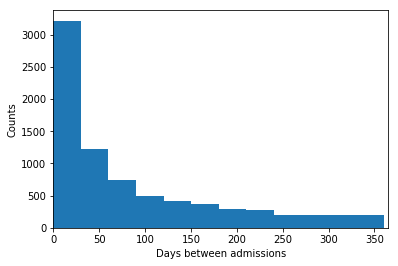

In [45]:
# plot a histogram of days between readmissions if they exist
# this only works for non-null values so you have to filter
plt.hist(df_adm.loc[~df_adm.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins =range(0,365,30))
plt.xlim([0,365])
plt.xlabel('Days between admissions')
plt.ylabel('Counts')
plt.show()

In [46]:
print('Number with a readmission:', (~df_adm.DAYS_NEXT_ADMIT.isnull()).sum())
print('Total Number:', len(df_adm))

Number with a readmission: 11399
Total Number: 58976


## Load the notes

In [47]:
df_notes = pd.read_csv("data/NOTEEVENTS.csv")

C:\Users\3236283\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [48]:
print('Number of notes:',len(df_notes))

Number of notes: 2083180


There can be multiple notes per hospitalizations so don't worry that the number of notes is higher than the number of hospitalizations. 

In [49]:
df_notes.CATEGORY.unique()

array(['Discharge summary', 'Echo', 'ECG', 'Nursing', 'Physician ',
       'Rehab Services', 'Case Management ', 'Respiratory ', 'Nutrition',
       'General', 'Social Work', 'Pharmacy', 'Consult', 'Radiology',
       'Nursing/other'], dtype=object)

In [50]:
df_notes.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [ ]:
# look at the first note
df_notes.TEXT.iloc[0]

We can see that the dates and PHI have been converted for confidentiality. There are '\n' characters, numbers and punctuation. 

At this point, we have to make a choice on what notes to use. For simplicity, let's use the discharge summary, but we could use all the notes by concatenating them. 

In [51]:
# filter to discharge summary
df_notes_dis_sum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']

In [52]:
assert df_notes_dis_sum.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

AssertionError: Multiple discharge summaries per admission

In [ ]:
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
assert df_notes_dis_sum_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

## Merge data sets

In [ ]:
df_adm_notes = pd.merge(df_adm[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT',\
                                'NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
                        df_notes_dis_sum_last[['SUBJECT_ID','HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')
assert len(df_adm) == len(df_adm_notes), 'Number of rows increased'

Check to see if there are alot of notes that are missing text (might be a sign of a problem).

In [ ]:
df_adm_notes.groupby('ADMISSION_TYPE').apply(\
                lambda g: g.TEXT.isnull().sum())/df_adm_notes.groupby('ADMISSION_TYPE').size()

Remove NEWBORN

In [ ]:
df_adm_notes_clean = df_adm_notes.loc[df_adm_notes.ADMISSION_TYPE != 'NEWBORN'].copy()

In [ ]:
print('Fraction of missing notes:', df_adm_notes_clean.TEXT.isnull().sum() / len(df_adm_notes_clean))
print('Fraction notes with newlines:', df_adm_notes_clean.TEXT.str.contains('\n').sum() / len(df_adm_notes_clean))
print('Fraction notes with carriage returns:', df_adm_notes_clean.TEXT.str.contains('\r').sum() / len(df_adm_notes_clean))

Additional analysis might be required to see if there are any specific cases why a discharge would not appear. For now, we will push forward. 